In [1]:
'''
This notebook does the same analytics as regressors.ipynb, except it runs 
each regressor in a separate thread, because sklearn is not multithreaded.
'''

%matplotlib inline
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

import random
import pandas
import numpy
import tensorflow
import time

from sklearn import metrics
from sklearn import preprocessing
from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split

# import various kinds of regressors
from sklearn import ensemble
from sklearn import tree
from sklearn import neighbors
from sklearn import linear_model

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
%%time
# use the same dataset as used by recommender
df_raw = pandas.read_csv('../data/etl2M.csv',header=None)
df_x = df_raw.ix[:, 1:17]   # x = features (observations)
df_y = df_raw.ix[:, 18]     # y = labels

x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, 
    test_size=500, 
    random_state=42,
    )

CPU times: user 4.33 s, sys: 504 ms, total: 4.83 s
Wall time: 4.83 s


In [3]:
%%time

def regressor(ith, algo_name, algorithm):
    tstart = time.time()
    model = algorithm.fit(x_train, y_train)
    y_predicted = model.predict(x_test)                                                                                                              
    tend = time.time()

    tsec = tend - tstart
    tmin = tsec // 60
    tsec = tsec %  60
    thrs = tmin // 60
    tmin = tmin %  60
    tuse = 'time=%02d:%02d:%02d' % (thrs, tmin, tsec)

    score = model.score(x_test, y_test)
    score = 'score={0:f}'.format(score)

    # sort to make plot look not so fuzzy
    # intact y_test & y_predicted for next algorithm !!!
    p_test, p_predicted = zip(*sorted(zip(y_test, y_predicted)))

    fig, ax = plt.subplots()
    fig.set_size_inches(16, 8)
    plt.scatter(numpy.arange(1, x_test.shape[0]+1, 1), p_test,      c='b', label='ground truth') 
    plt.scatter(numpy.arange(1, x_test.shape[0]+1, 1), p_predicted, c='r', label='prediction')                                                                                                  
    plt.axis('tight')                                                                                                                           
    plt.legend()                                                                                                                                
    plt.title("%s: %s %s" % (algo_name, tuse, score))                                                                                                                                      
    plt.savefig("/data/tmp/%s.png" % algo_name) 
    plt.grid()
    plt.show()
    plt.clf()


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.96 µs


In [4]:
algorithms = {
    'DecisionTreeRegressor':      tree.DecisionTreeRegressor(),
    'ExtraTreeRegressor':         tree.ExtraTreeRegressor(),
    'RandomForestRegressor':      ensemble.RandomForestRegressor(n_estimators=40),
    'AdaBoostRegressor':          ensemble.AdaBoostRegressor(),
    'GradientBoostingRegressor':  ensemble.GradientBoostingRegressor(),
    'KNeighborsRegressor':        neighbors.KNeighborsRegressor(5, weights='distance'),
    'LinearRegression':           linear_model.LinearRegression(),
    'LogisticRegression':         linear_model.LogisticRegression(),
    'BayesianRidge':              linear_model.BayesianRidge(),
}                                  

In [5]:
%%time

'''
Multithreading doesn't work on jupyter when any thread 
can take long time to finish !!
'''
import threading

if False:
    threads = []
    for i, algo_name in enumerate(algorithms):
        algorithm = algorithms[algo_name]
        t = threading.Thread(target = regressor, args=(i, algo_name, algorithm))
        threads.append(t)
        t.start()

    print '%d regressors are running...' % len(threads)
    [t.join() for t in threads]

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 14.1 µs


In [6]:
import os

# fork a child for each regressor
for i, algo_name in enumerate(algorithms):
    algorithm = algorithms[algo_name]
    
    #remove each png
    os.remove("/data/tmp/%s.png" % algo_name)
    
    child = os.fork()
    if child == 0:
        regressor(i, algo_name, algorithm)
        os._exit(0)
    else:
        print "forked %d for %s" % (child, algo_name)


forked 7422
forked 7423
forked 7424
forked 7425
forked 7426
forked 7427
forked 7428
forked 7429
forked 7430


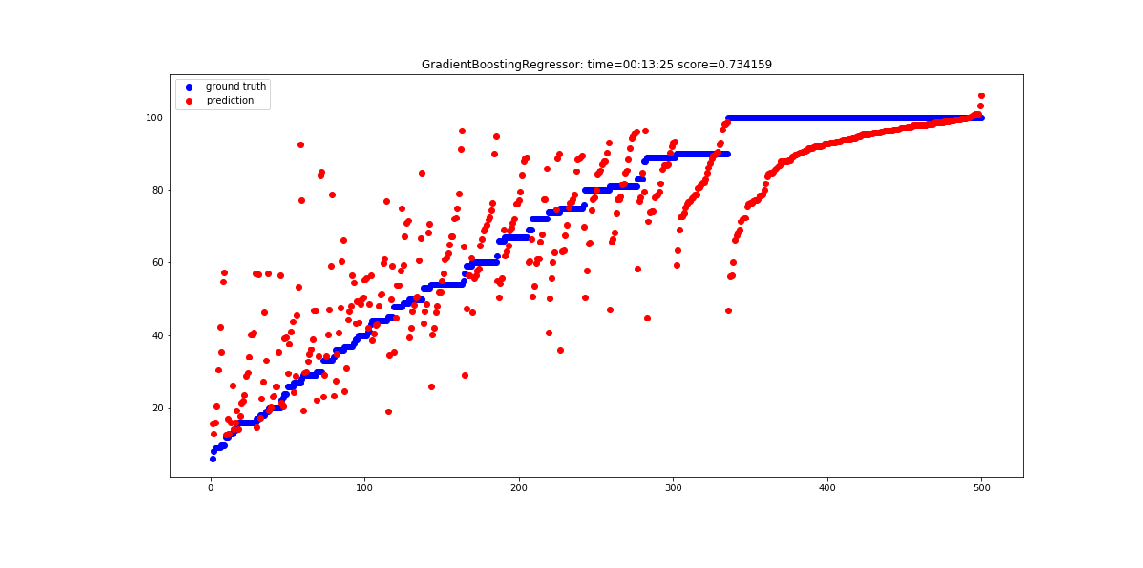

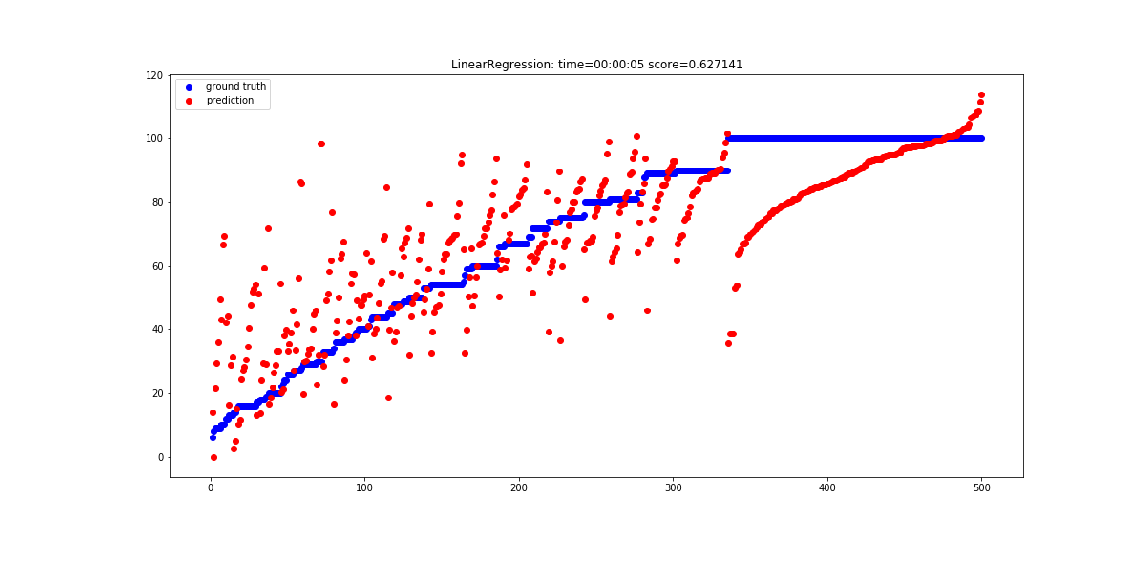

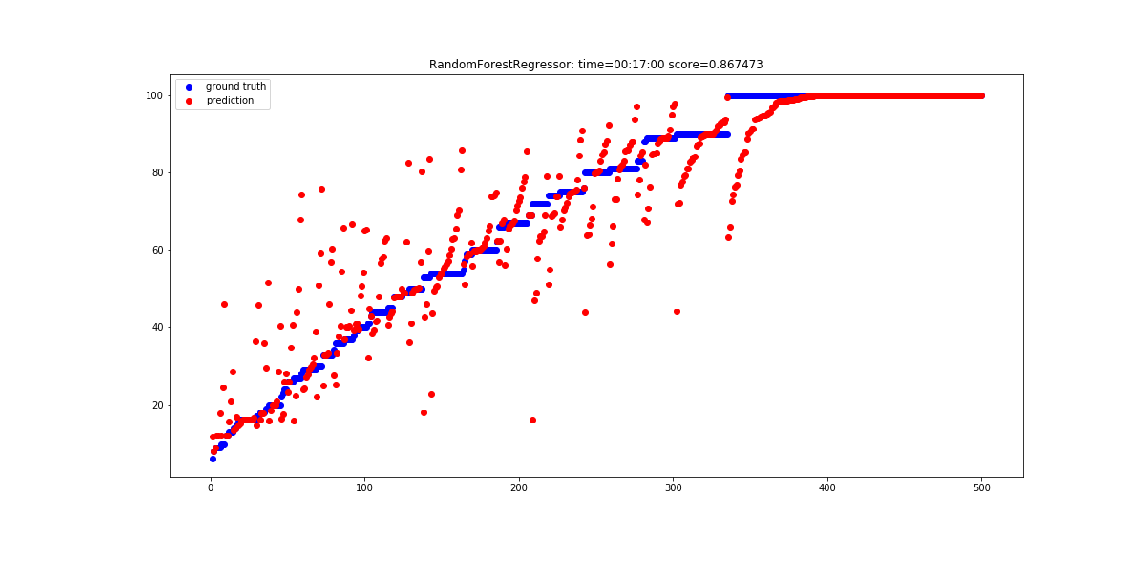

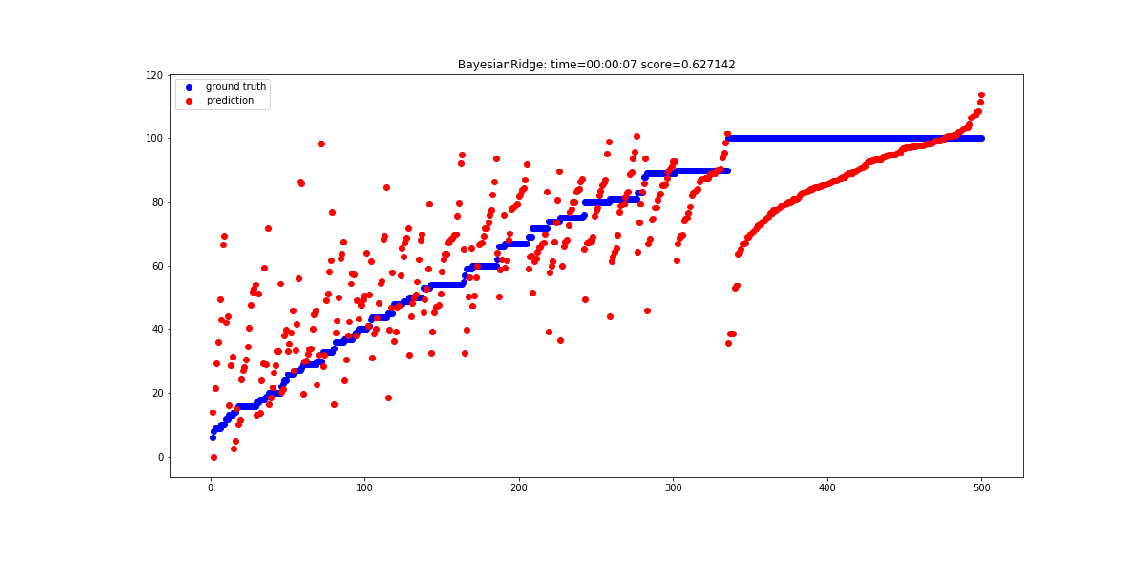

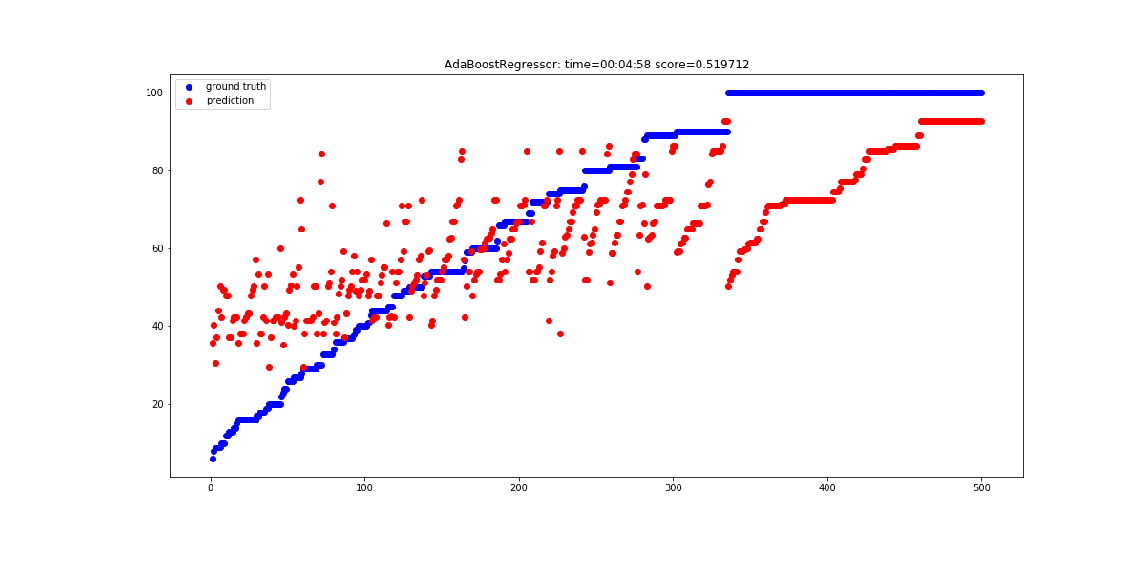

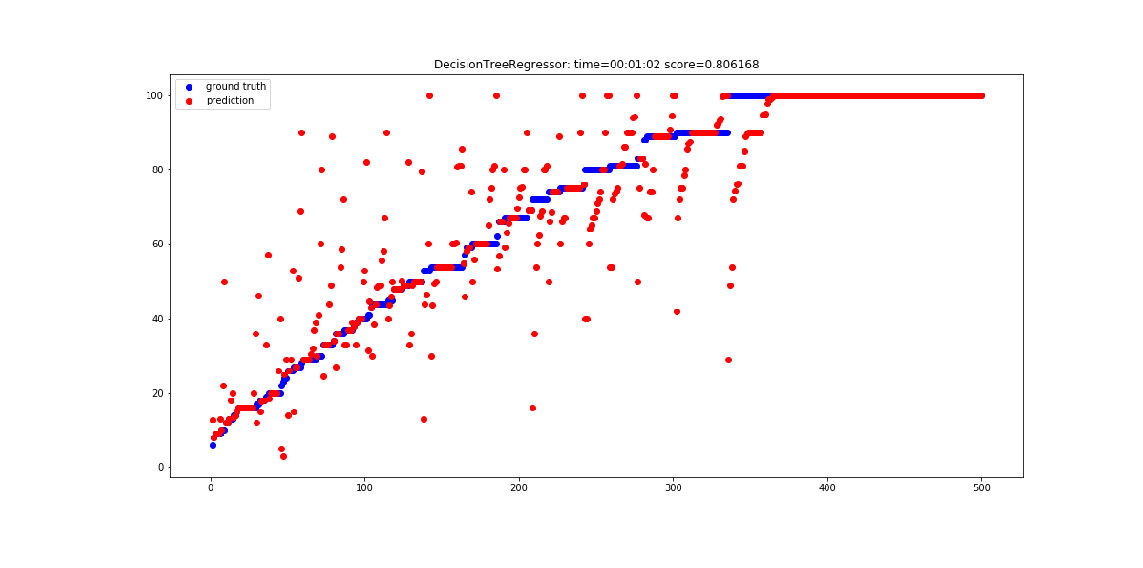

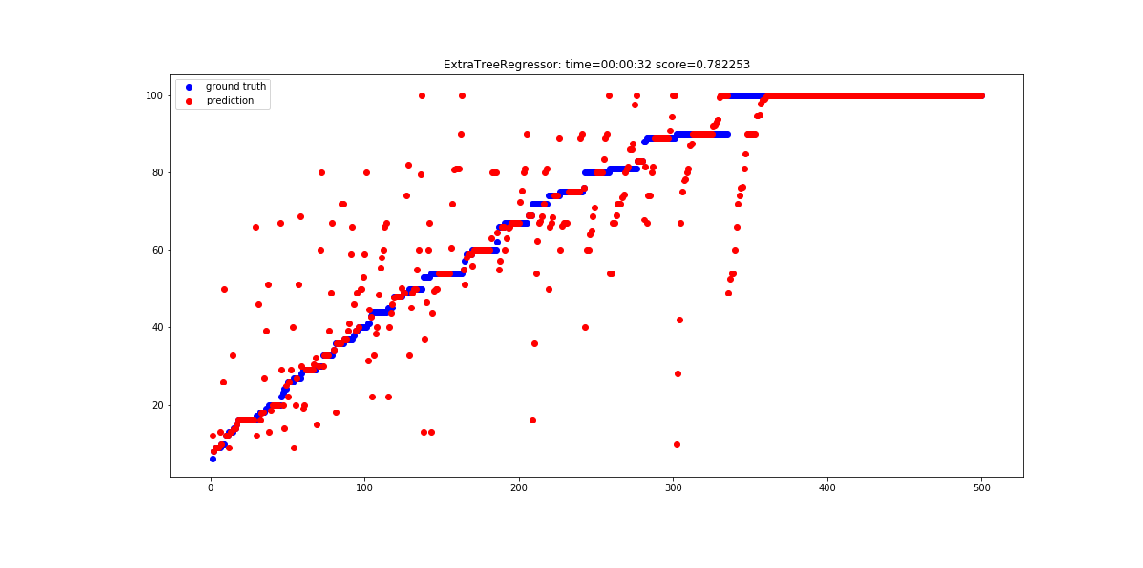

In [ ]:
import matplotlib.image as mpimg

pngs = []
for i, algo_name in enumerate(algorithms):
    pngs.append("/data/tmp/%s.png" % algo_name)

while len(pngs) > 1:
    for png in pngs:
        if os.path.isfile(png):
            # show same size w/i axis or margin
            fig, ax = plt.subplots()
            fig.set_size_inches(16, 8)
            plt.axis('off')     # no axis
            plt.tight_layout()  # no margins

            img = mpimg.imread(png)
            imgplot = plt.imshow(img, aspect='auto')

            plt.show()
            plt.clf()
            
            # no more
            pngs.remove(png)

    # till all showed
    time.sleep(5) 